# Precipitation Forecasting using XGBoost

In this notebook, we investigate XGBoost (eXtreme Gradient Boosting) as a model to forecast precipitation. XGBoost is an efficient implementation of gradient boosting machines that builds an ensemble of decision trees sequentially. Each tree tries to correct the errors made by the previous trees. Unlike RNNs which maintain internal states, XGBoost treats our time series data as a traditional supervised learning problem where we flatten the temporal sequences into feature vectors.

## 0. Imports and Basic Setup

In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## 1. Load Preprocessed Train, Validation, and Test Splits


In [2]:
train_data = pd.read_csv("../data/processed/train_data.csv")
validation_data = pd.read_csv("../data/processed/validation_data.csv")
test_data = pd.read_csv("../data/processed/test_data.csv")

# Sort splits by location -> YYYY -> DOY to ensure correct time ordering
train_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
validation_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
test_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)

## 2. Create Sequences for XGBoost


In [3]:
def create_sequences(df, feature_cols, target_col, seq_length=30):
    """
    Create sequences for time series prediction, grouped by location.
    Unlike RNNs which keep the temporal dimension, we flatten the sequences
    for XGBoost into a single feature vector.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with time series data
    feature_cols (list): List of feature column names
    target_col (str): Name of the target column
    seq_length (int): Length of sequence to use for prediction
    
    Returns:
    tuple: (X array of shape (n_samples, seq_length * n_features),
            y array of shape (n_samples,))
    """
    X_list, y_list = [], []
    grouped = df.groupby("location", group_keys=True)
    
    for loc, loc_df in grouped:
        loc_df = loc_df.reset_index(drop=True)
        loc_features = loc_df[feature_cols].values
        loc_target = loc_df[target_col].values
        
        for i in range(len(loc_df) - seq_length):
            # Flatten the sequence into a single feature vector
            sequence = loc_features[i:i + seq_length].flatten()
            X_list.append(sequence)
            y_list.append(loc_target[i + seq_length])
    
    return np.array(X_list), np.array(y_list)

## 3. Define Features and Target


In [4]:
exclude_cols = ["location", "YYYY", "DOY", "MM", "DD", "prec"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]
target_col = "prec"

print("Feature columns:", feature_cols)
print("Target column:", target_col)

Feature columns: ['2m_temp_max', '2m_temp_mean', '2m_temp_min', '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u', '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe', 'surf_net_solar_rad_max', 'surf_net_solar_rad_mean', 'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press', 'total_et', 'volsw_123', 'volsw_4']
Target column: prec


## 4. Generate sequences

In [5]:
SEQ_LENGTH = 30
X_train, y_train = create_sequences(train_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_val, y_val = create_sequences(validation_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, feature_cols, target_col, seq_length=SEQ_LENGTH)

print("Train sequence shape:", X_train.shape, y_train.shape)
print("Validation sequence shape:", X_val.shape, y_val.shape)
print("Test sequence shape:", X_test.shape, y_test.shape)

Train sequence shape: (1202420, 600) (1202420,)
Validation sequence shape: (106720, 600) (106720,)
Test sequence shape: (106620, 600) (106620,)


##  5. Build and Train XGBoost Model


In [6]:
# Create feature names for interpretation
feature_names = [f"{col}_t{i}" for i in range(SEQ_LENGTH) for col in feature_cols]

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # regression task
    'eval_metric': ['rmse', 'mae'],   # metrics to evaluate
    'max_depth': 6,                   # maximum depth of trees
    'learning_rate': 0.01,            # learning rate
    'subsample': 0.8,                 # fraction of samples used for tree building
    'colsample_bytree': 0.8,          # fraction of features used for tree building
    'min_child_weight': 1,            # minimum sum of instance weight in a child
}

# Train model with early stopping
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-rmse:0.99900	train-mae:0.66591	val-rmse:1.02142	val-mae:0.67763
[100]	train-rmse:0.93163	train-mae:0.60601	val-rmse:0.95965	val-mae:0.62570
[200]	train-rmse:0.90792	train-mae:0.58312	val-rmse:0.94274	val-mae:0.60776
[300]	train-rmse:0.89496	train-mae:0.57105	val-rmse:0.93583	val-mae:0.59914
[400]	train-rmse:0.88615	train-mae:0.56374	val-rmse:0.93284	val-mae:0.59483
[500]	train-rmse:0.87887	train-mae:0.55842	val-rmse:0.93099	val-mae:0.59214
[600]	train-rmse:0.87246	train-mae:0.55422	val-rmse:0.92952	val-mae:0.59020
[700]	train-rmse:0.86679	train-mae:0.55084	val-rmse:0.92847	val-mae:0.58895
[800]	train-rmse:0.86177	train-mae:0.54777	val-rmse:0.92758	val-mae:0.58789
[900]	train-rmse:0.85705	train-mae:0.54503	val-rmse:0.92708	val-mae:0.58719
[999]	train-rmse:0.85276	train-mae:0.54253	val-rmse:0.92650	val-mae:0.58647


## 6. Evaluate the Model

In [7]:
# Make predictions
val_preds = model.predict(dval)
test_preds = model.predict(dtest)

# Calculate metrics for validation set
val_mse = mean_squared_error(y_val, val_preds)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, val_preds)

print(f"Validation MSE:  {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE:  {val_mae:.4f}")

# Calculate metrics for test set
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_preds)

print(f"\nTest MSE:  {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE:  {test_mae:.4f}")

Validation MSE:  0.8584
Validation RMSE: 0.9265
Validation MAE:  0.5865

Test MSE:  0.8393
Test RMSE: 0.9161
Test MAE:  0.5896


## 7. Visualize Predictions

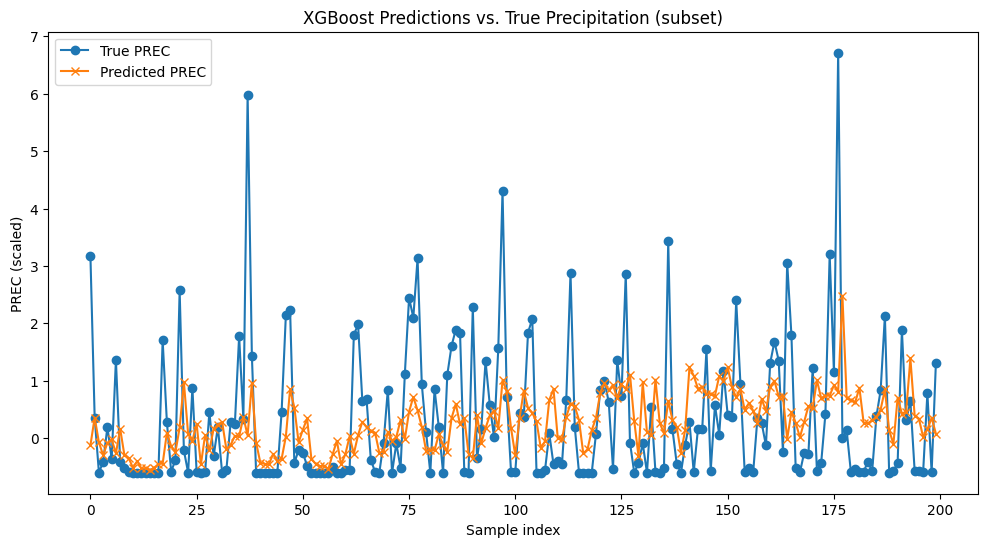

In [8]:
num_samples_to_plot = 200
plt.figure(figsize=(12,6))
plt.plot(y_test[:num_samples_to_plot], label='True PREC', marker='o')
plt.plot(test_preds[:num_samples_to_plot], label='Predicted PREC', marker='x')
plt.title("XGBoost Predictions vs. True Precipitation (subset)")
plt.xlabel("Sample index")
plt.ylabel("PREC (scaled)")
plt.legend()
plt.show()

## 8. Feature Importance Study


To investigate feature importance in XGBoost models, we measure the gain of certain variables. The gain in XGBoost measures the average improvement in the loss function (e.g., RMSE) achieved by splits using a specific feature across all trees. A higher gain indicates that the feature contributes more significantly to reducing prediction error.  

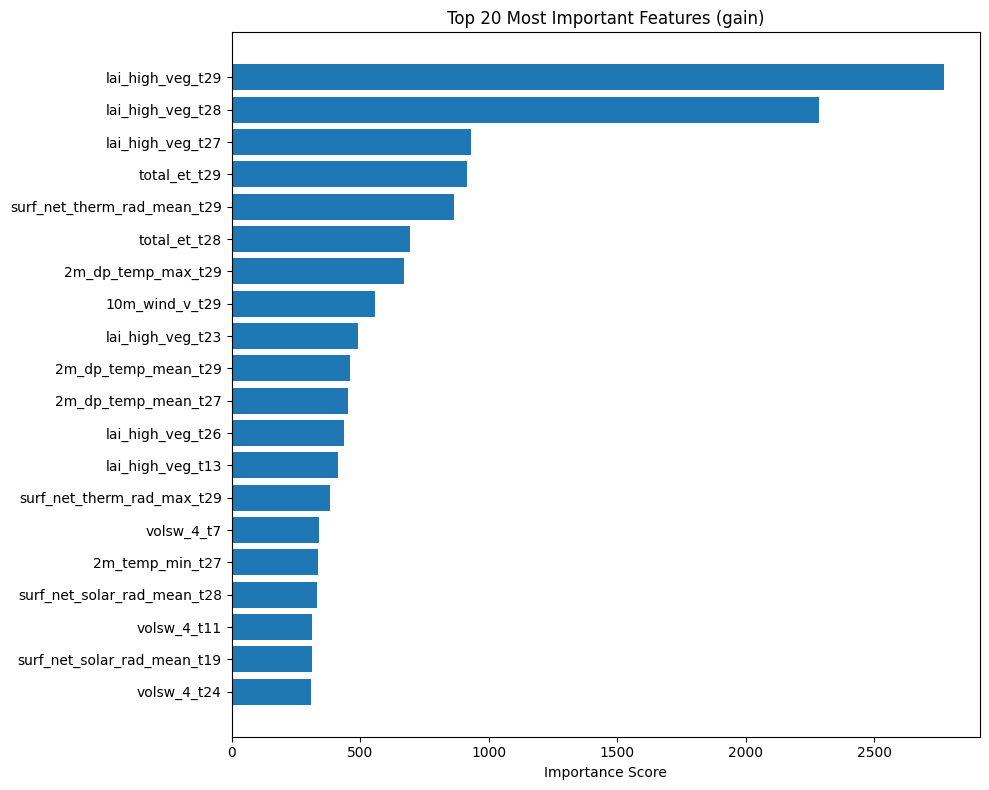

In [9]:
# Get feature importance scores
importance_scores = model.get_score(importance_type='gain')
importance_df = pd.DataFrame(
    [(k, v) for k, v in importance_scores.items()],
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].tail(20), importance_df['Importance'].tail(20))
plt.title('Top 20 Most Important Features (gain)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


## 9. Analyze Temporal Importance


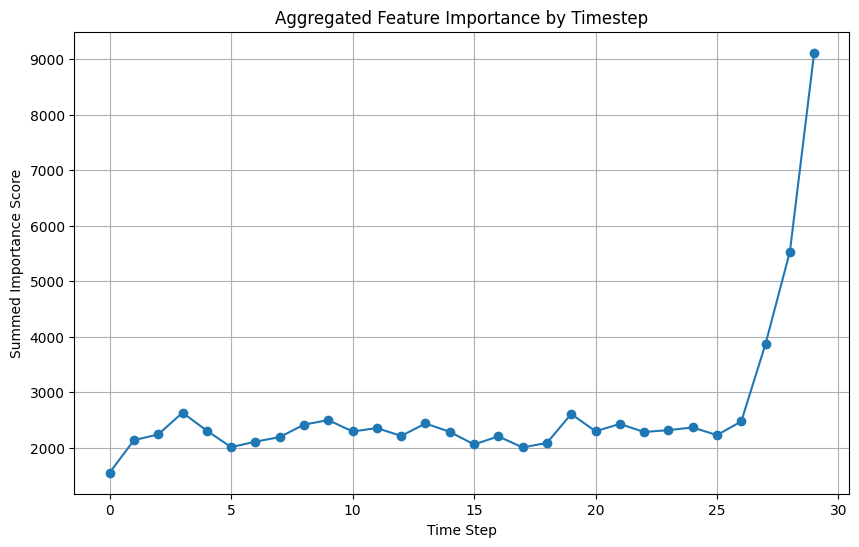

In [10]:
# Extract timesteps from feature names and aggregate importance by time
def extract_timestep(feature_name):
    return int(feature_name.split('_t')[-1])

importance_df['timestep'] = importance_df['Feature'].apply(extract_timestep)
temporal_importance = importance_df.groupby('timestep')['Importance'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(temporal_importance['timestep'], temporal_importance['Importance'], marker='o')
plt.title('Aggregated Feature Importance by Timestep')
plt.xlabel('Time Step')
plt.ylabel('Summed Importance Score')
plt.grid(True)
plt.show()

Here, we can see that, as one would expect, the later time steps are much more important than the earlier ones